### FrameFlow Video Classification of the UCF101 dataset - subset version using Bayesian optimisation
 - Using the EfficientNetB0 pre-trained model with adapated layers for CNN
 - The aim of this notebook is to identify a suitable learning rate using a subset of UCF101 dataset
 - Using Bayesian optimisation technique to determine a more optimal learning rate before applying to a larger set in another notebook project
 

FrameFlow: Video Classification with Pre-trained CNNs

This project, titled 'FrameFlow', utilizes the power of convolutional neural networks (CNNs) 
pre-trained on large datasets to perform video classification tasks. The focus of FrameFlow 
is to apply transfer learning techniques to adapt these sophisticated models to the domain 
of action recognition in video data.

Key Components:
- Dataset Preparation: Organize and prepare video data, extracting frames and corresponding labels.
- Model Selection: Employ EfficientNetB0, a pre-trained model known for its efficiency and accuracy.
- Transfer Learning: Fine-tune the pre-trained model on a specific subset of the UCF101 dataset, targeting action recognition.
- Evaluation: Assess model performance using metrics such as accuracy, F1 score, and a confusion matrix.

By leveraging pre-trained models, FrameFlow seeks to minimize the need for extensive computational resources while maintaining high levels of accuracy. This approach is particularly beneficial when working with limited datasets or aiming for rapid prototyping.



In [1]:
# Setup the notebook.
# If using Anaconda then install TensorFLow 2.10.0 for this to work
# pip install -U "tensorflow>=2.10.0"
# Please also download the subset dataset from my account. The publicly available dataset link will also be provided. 
# https://drive.google.com/file/d/1aZRf3BDh52-Oz-Uz3YgY8eq_amSaiH1x/view?usp=sharing
# The above subset contains files from https://www.crcv.ucf.edu/research/data-sets/ucf101/

In [2]:
import pathlib
import os
from pathlib import PosixPath
import numpy as np
import cv2
import random
import tensorflow as tf
import collections
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Importing modules for filesystem path manipulation and operating system interaction
# Importing numpy for numerical operations and array manipulations
# Importing OpenCV for computer vision tasks and random for random number generation
# Importing TensorFlow for machine learning and deep learning operations
# Importing collections for specialized container datatypes
# Importing matplotlib and seaborn for data visualization and plotting
# Importing sklearn for machine learning metrics like the confusion matrix


### Optional GPU check if compatible with your environment

In [3]:
!nvcc --version # Check CUDA version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
# Optional check with Pytorch to see which CUDA version is avail
# import torch
# print(torch.cuda.is_available())
# print(torch.version.cuda)

True
12.1


In [5]:
# Set CUDA system variables
os.environ["CUDA_HOME"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1"
os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin"


In [6]:
# Print TensorFLow Version and output GPU availability
# for GPU it may say [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(True)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare and load the datasest

In [7]:
# Set globally thge base directory of the dataset
base_dir = Path('./UCF101_subset')  # Update this path to your dataset location

# Define the paths to the dataset splits
subset_paths = {
    'train': base_dir / 'train',
    'val': base_dir / 'val',
    'test': base_dir / 'test'
}

In [8]:
# Check Directory structure of the dataset
def check_directory_structure(base_dir):
    base_path = pathlib.Path(base_dir)
    if not base_path.exists():
        print(f"Base directory {base_dir} does not exist.")
        return

    # List splits
    for split in ['train', 'val', 'test']:
        split_path = base_path / split
        if not split_path.exists():
            print(f"Missing '{split}' directory in {base_dir}")
            continue

        # List class directories in each split
        class_dirs = [d for d in split_path.iterdir() if d.is_dir()]
        print(f"\nIn '{split}' split:")
        if not class_dirs:
            print(f"No class directories found in {split_path}")
            continue

        for class_dir in class_dirs:
            # Count video files in each class directory
            video_files = list(class_dir.glob('*.avi'))
            print(f"Class '{class_dir.name}' has {len(video_files)} video files")

# Usage
check_directory_structure(base_dir)


In 'train' split:
Class 'ApplyEyeMakeup' has 34 video files
Class 'ApplyLipstick' has 30 video files
Class 'Archery' has 30 video files
Class 'BabyCrawling' has 30 video files
Class 'BalanceBeam' has 30 video files
Class 'BandMarching' has 30 video files
Class 'BaseballPitch' has 30 video files
Class 'Basketball' has 30 video files
Class 'BasketballDunk' has 30 video files
Class 'BenchPress' has 30 video files

In 'val' split:
Class 'ApplyEyeMakeup' has 10 video files
Class 'ApplyLipstick' has 10 video files
Class 'Archery' has 10 video files
Class 'BabyCrawling' has 10 video files
Class 'BalanceBeam' has 10 video files
Class 'BandMarching' has 10 video files
Class 'BaseballPitch' has 10 video files
Class 'Basketball' has 10 video files
Class 'BasketballDunk' has 10 video files
Class 'BenchPress' has 10 video files

In 'test' split:
Class 'ApplyEyeMakeup' has 10 video files
Class 'ApplyLipstick' has 10 video files
Class 'Archery' has 10 video files
Class 'BabyCrawling' has 10 video fi

In [9]:
def verify_local_dataset_structure(base_dir, splits, expected_num_classes, files_per_class):
    """Verify the local dataset structure

    Args:
      base_dir: The base directory where the dataset is stored.
      splits: A list of the dataset splits (e.g., ["train", "val", "test"]).
      expected_num_classes: The expected number of classes in the dataset.
      files_per_class: The expected minimum number of video files per class.

    Returns:
      A boolean indicating whether the local dataset structure is as expected.
    """
    base_dir = pathlib.Path(base_dir)

    for split in splits:
        split_dir = base_dir / split
        if not split_dir.exists() or not split_dir.is_dir():
            print(f"Directory for '{split}' split does not exist.")
            return False

        class_dirs = list(split_dir.glob('*'))
        if len(class_dirs) < expected_num_classes:
            print(f"Not enough class directories in '{split}' split.")
            return False

        for class_dir in class_dirs:
            if not class_dir.is_dir():
                continue  # Skip non-directory files

            video_files = list(class_dir.glob('*.avi'))
            if len(video_files) < files_per_class:
                print(f"Not enough video files in class '{class_dir.name}' within '{split}' split.")
                return False

    return True

def load_local_ucf101_dataset(base_dir, splits=["train", "val", "test"], expected_num_classes=10, files_per_class=10):
    """Load the UCF101 dataset from local directories.

    Args:
      base_dir: The base directory where the dataset splits are stored.
      splits: The dataset splits to load (default: ["train", "val", "test"]).
      expected_num_classes: The expected number of classes in the dataset (default: 101 for UCF101).
      files_per_class: The expected minimum number of video files per class (for verification).

    Returns:
      A dictionary with keys as split names and values as paths to the directories, if the structure is verified.
      Otherwise, returns None.
    """
    if verify_local_dataset_structure(base_dir, splits, expected_num_classes, files_per_class):
        print("Local dataset structure verified successfully.")
        return {split: pathlib.Path(base_dir) / split for split in splits}
    else:
        print("Local dataset structure verification failed.")
        return None

In [10]:
# Verify local dataset
dataset_splits = load_local_ucf101_dataset(base_dir)

if dataset_splits:
    print("Dataset loaded successfully:")
    for split, path in dataset_splits.items():
        print(f"{split}: {path}")
else:
    print("Failed to load dataset.")
    
print ("\n", dataset_splits) # Subset should contain train, val and test in the dictionary.
print ("\n")

for split, path in dataset_splits.items():
    print(f"Checking path for {split}: {path}")
    print(f"Full path: {path.resolve()}")

Local dataset structure verified successfully.
Dataset loaded successfully:
train: UCF101_subset\train
val: UCF101_subset\val
test: UCF101_subset\test

 {'train': WindowsPath('UCF101_subset/train'), 'val': WindowsPath('UCF101_subset/val'), 'test': WindowsPath('UCF101_subset/test')}


Checking path for train: UCF101_subset\train
Full path: C:\Users\gwrip\Documents\Machine_Learning\Imperial College Business School Course\Capstone Project\MainCapstone FrameFlow\UCF101_subset\train
Checking path for val: UCF101_subset\val
Full path: C:\Users\gwrip\Documents\Machine_Learning\Imperial College Business School Course\Capstone Project\MainCapstone FrameFlow\UCF101_subset\val
Checking path for test: UCF101_subset\test
Full path: C:\Users\gwrip\Documents\Machine_Learning\Imperial College Business School Course\Capstone Project\MainCapstone FrameFlow\UCF101_subset\test


In [11]:
# Output total number of videos in the subset folder

total_videos = 0
for split in dataset_splits.values():
    total_videos += len(list(split.glob('**/*.avi')))  # Note the '**/' for recursive search
print(f"Total Videos: {total_videos}")


Total Videos: 505


In [12]:
sample_path = dataset_splits['train']  # Example: checking the 'train' split
print(f"Sample path to check: {sample_path}")

# Use '**/*.avi' to recursively search for .avi files in all subdirectories
avi_files = list(sample_path.glob('**/*.avi'))

print(f"Number of .avi files found: {len(avi_files)}")
print("First 5 .avi files found:", avi_files[:5])  # Print first 5 .avi files, if any


Sample path to check: UCF101_subset\train
Number of .avi files found: 305
First 5 .avi files found: [WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi'), WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g03_c03.avi'), WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g03_c05.avi'), WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g04_c03.avi'), WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g04_c05.avi')]


In [13]:
# !find ./UCF101_subset # List within notebook sub-folder file views

In [14]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.name.split('_')[-3]

In [15]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [16]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

# List all .avi files in the 'train' directory (or 'val', 'test' depending on your requirement)
files = list(base_dir.glob('train/*/*.avi'))  # Adjust the path if your dataset structure is different

files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 10
Num videos for class[0]: 34


In [17]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [18]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress']

### Read video data and visualise

In [19]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [20]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 3):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [21]:
# Check File Exists to display test frames
video_path = "./UCF101_subset/train/BasketballDunk/v_BasketballDunk_g01_c04.avi"
absolute_video_path = os.path.abspath(video_path)
print("Absolute video path:", absolute_video_path)
print("File exists:", os.path.exists(absolute_video_path))

Absolute video path: C:\Users\gwrip\Documents\Machine_Learning\Imperial College Business School Course\Capstone Project\MainCapstone FrameFlow\UCF101_subset\train\BasketballDunk\v_BasketballDunk_g01_c04.avi
File exists: True


In [22]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

### Visualise data example

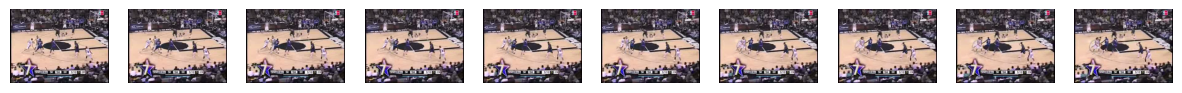

In [23]:
# Use the CV2 library to display 10 frames from the example vile
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")

# Number of frames you want to display
num_frames_to_display = 10

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, num_frames_to_display, figsize=(15, 5))

for i in range(num_frames_to_display):
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB for correct matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axs[i].imshow(frame_rgb)
        axs[i].axis('off')
    else:
        print(f"Failed to read frame {i}")
        break

plt.show()
cap.release()


In [24]:
def check_for_black_frames(frames):
    black_frames_indices = []
    for i, frame in enumerate(frames):
        if np.all(frame == 0):  # Check if all pixel values in the frame are 0 (black)
            black_frames_indices.append(i)
    return black_frames_indices

# Assuming 'sample_video' contains your extracted frames
black_frames_indices = check_for_black_frames(sample_video)

if black_frames_indices:
    print(f"Black frames found at indices: {black_frames_indices}")
else:
    print("No black frames found.")


No black frames found.


In [25]:
#Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
else:
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames in the video: {total_frames}")

# Release the video capture object
cap.release()


Total number of frames in the video: 61


In [26]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [27]:
# Test the frame generator. Data should be shuffled.
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

# Number of frames, 224 by 224 pixel and number of colour channels should be 3
# Should print what correspondong label

Shape: (10, 224, 224, 3)
Label: 7


### Dataset creation for Training

In [28]:
# Create the training set

# Define the output signature for the dataset elements.
# This is necessary because the dataset is being created from a generator,
# and TensorFlow needs to know the structure and data types of the elements it will contain.

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), # For video frames
                    tf.TensorSpec(shape = (), dtype = tf.int16)) # For labels

# Create the training dataset using a generator.
# Specify the generator function: FrameGenerator instance configured for the training data.
# This generator yields pairs of video frames and their corresponding labels.
# Provide the output signature: a tuple defining the structure and data types of the dataset elements.
# The first element of the tuple corresponds to video frames, which are expected to be 4D tensors
# with shape (batch_size, height, width, 3) where 3 stands for the RGB color channels.
# The batch size and spatial dimensions are left unspecified (None), as they can vary.
# The second element of the tuple corresponds to labels, which are scalar integers (no dimensions, shape ()).
 
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)


In [29]:
train_ds

<FlatMapDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int16, name=None))>

In [30]:
# Check the dataset is shuffled, check the labels of the first few batches in the dataset

for frames, labels in train_ds.take(10): # Iterate over the first 10 elements of the dataset
  print(labels) #Output the labels for each set

tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)


In [31]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [32]:
for frames, labels in val_ds.take(10): # Iterate over the first 10 elements of the dataset
  print(labels) #Output the labels for each set

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)


In [33]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [34]:
# Configure daatest for performance
# Prefetching, ensure dataset does not become bottleneck while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [35]:
# Prep data for the model, using batching.
# Shape of data is 5 dimensions : batch size, number of frames, height, width, channells

train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


### Model training with Bayesian optimisation (focusing on learning rate)

 - The provided code defines a function objective that acts as the core for training and evaluating a machine learning model for video classification. Here's a breakdown of what it does:

Extracts Learning Rate:

- It takes a list of parameters (params) as input and extracts the first element (learning_rate).
Model Setup:

- It defines a pre-trained model (EfficientNetB0) used for feature extraction from video frames. This model is typically frozen (weights not updated) during initial training.
It then adds custom layers on top of the pre-trained model for video classification. These custom layers are trainable.
Model Compilation:

- It creates an optimizer (Adam) using the provided learning rate.
It compiles the model with the optimizer, a specific loss function (SparseCategoricalCrossentropy), and an accuracy metric.
Model Training and Evaluation:

- It trains the model on the provided training data (train_ds) for a set number of epochs (5 in this case).
It uses the validation data (val_ds) to monitor the validation loss during training. An early stopping callback is included to stop training if the validation loss doesn't improve for 2 epochs.
Return Values:

- It returns the minimum validation loss encountered during training (min(history.history['val_loss'])).
Additionally, it returns the trained model itself for potential further evaluation.
Key Point:

- This function plays a crucial role in the hyperparameter tuning process. It allows the optimization loop to evaluate different learning rates by training the model with each rate, measuring the validation loss, and ultimately finding the learning rate that leads to the best performance (lowest validation loss) on the validation dataset.

In [36]:
# Objective function: Trains the model and returns the validation loss and the best model
# The core of the model training and validation 
# Initializes and compiles your model with the given learning rate.
# Trains the model on your training dataset for a predefined number of epochs.
# Evaluates the model on your validation dataset to obtain the validation loss.
# Returns the validation loss (which the optimization process aims to minimize) and the trained model itself for potential further evaluation.

def objective(params):
    learning_rate = params[0]  # Ensure learning_rate is treated as a scalar
    
    # The pre-trained layers are typically "frozen," meaning their weights are not updated during the first phase of training. 
    # This ensures that the rich feature detectors learned on ImageNet are not destroyed.    
    # Model definition - custom layers added to pre-trained NN
    net = tf.keras.applications.EfficientNetB0(include_top=False)
    net.trainable = False
    
    # Add custom layers which will be trained from scratch
    # These are crucial for adapating the pre-trained network for video
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(scale=255),     # Normalisation pixel values 0-1 for input frames
        tf.keras.layers.TimeDistributed(net),     # Wrapper allows EfficentNet80 to process each frane independently. Spatial feaatures are extracted for each frame. Without this we cannot apply CNN to each frame independtly
        tf.keras.layers.Dense(10),                # Fully connected lahyer with 10 units for each class of which there are ten in this subset used
        tf.keras.layers.GlobalAveragePooling3D()  # global averaging for temporal/spatial compressing features extracted from video frame suitable for final classification layer
    ])

    # Compile the model with the given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
   
    # Use the optimizer in model compilation 
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Fit the model
    # Model is first trained with the new layers
    history = model.fit(train_ds, epochs=5, validation_data=val_ds,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')])
    
    # Return the minimum validation loss and the trained model
    return min(history.history['val_loss']), model



The following section Sets Up a Gaussian Process Model:

It uses a Gaussian Process (GP) regressor to model the relationship between a hyperparameter (learning rate in this case) and the performance (loss) of a machine learning model.
The specific GP model uses an RBF kernel to capture smooth variations in the objective function.
Defines Search Space for Learning Rate:

It specifies a range of possible values (learning rates) to explore.
Optimization Loop:

It iterates for a set number of times.
In initial iterations, it randomly selects learning rates from the defined range.
Later, it uses the GP model to select the next learning rate to explore. This selection balances trying new learning rates (exploration) with focusing on promising ones (exploitation).
For each chosen learning rate:
It evaluates the performance (loss) of a model trained with that learning rate.
It updates the GP model with this new learning rate and its corresponding loss.
Throughout the loop, it keeps track of the best performing model (lowest loss).
Outputs Results:

After the loop finishes, it reports the best learning rate found and its corresponding loss.
This approach helps find an optimal learning rate for a machine learning model in an automated way.

In [37]:
# Setup the Gaussian Process Regressor
# This loop iterates through candidate learning rates, updating the Gaussian Process model with 
# new observations, and selecting the next learning rate based on the Upper Confidence Bound (UCB).

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
#from sklearn.preprocessing import StandardScaler

# Setup the Gaussian Process with RBF kernel
# The Gaussian Process (GP) Regressor is set up with an RBF kernel, which is a common choice for 
# modeling the smooth variations of the objective function with respect to the hyperparameters 
# (in this case, the learning rate). The GP provides a probabilistic model of the 
# objective function, allowing for predictions about the objective function's behavior in 
# unexplored regions of the hyperparameter space.

#kernel = RBF(length_scale=1.0, length_scale_bounds='fixed')
#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-20, 1e5))
# Combine the RBF kernel with a white noise kernel
# kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e-2), nu=1.5) + WhiteKernel(noise_level=1e-5)

kernel = RBF(length_scale=0.001, length_scale_bounds=(1e-4, 1e-1)) + WhiteKernel(noise_level=1e-5)

# Initialize GaussianProcessRegressor
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer='fmin_l_bfgs_b')


# Define the search space for the learning rate - given the default for TensorFlow is 0.001 and
# that prior tests show good performance on the test set at this rate including the full set
lr_min = 0.0005
lr_max = 0.002
#lr_min = 0.0001
#lr_max = 0.01

lr_values = np.linspace(lr_min, lr_max, 100).reshape(-1, 1)

# Scale your input data (learning rates)
# scaler = StandardScaler()
# lr_values_scaled = scaler.fit_transform(lr_values)


# Lists to store observed learning rates and corresponding losses
observed_lr = []
observed_loss = []

# Variables to store the best model and its performance
best_loss = float('inf')
best_model = None

# Optimization loop
# The optimization loop iterates over a predefined number of steps, selecting learning rates to 
# evaluate based on the strategy dictated by the GP model and the Upper Confidence Bound (UCB) 
# acquisition function.

# Initial Random Sampling: The first few iterations randomly select learning rates from the 
# search space to provide initial data to the GP model.
# Model Fitting and Prediction: After the initial phase, the GP model is fitted with the observed 
# learning rates and their corresponding validation losses. It then predicts the mean and standard 
# deviation (uncertainty) of the validation loss for each candidate learning rate.
# UCB for Learning Rate Selection: The UCB acquisition function is used to select the next learning 
# rate to evaluate, balancing exploration (trying unexplored learning rates with high uncertainty) 
# and exploitation (focusing on learning rates with low predicted validation loss).
# Objective Function Evaluation: For the selected learning rate, the objective function is called 
# to train the model and obtain the validation loss, which is then used to update the GP model.
    
num_iterations = 20 # Bump up to 20 if you have more computing/GPU power
initial_random_points = 10 #Random selections before applying GP
# beta = 1.5  # balance exploration/exploitation but leaning more towards exploitation
beta = 4  # lean much more towards more exploration

for iteration in range(num_iterations):
    if iteration < initial_random_points:  # Initial random sampling
        selected_lr = np.random.choice(lr_values.flatten(), size=1).reshape(-1, 1)
    else:  # Use GP to select the next learning rate
        gp_model.fit(np.array(observed_lr), np.array(observed_loss))  # Update GP with observations
        mean, std = gp_model.predict(lr_values, return_std=True)  # GP predictions
        ucb = mean + beta * std  # Upper Confidence Bound
        selected_lr = lr_values[np.argmax(ucb)].reshape(-1, 1)  # Select learning rate with max UCB

    # Evaluate the objective function with the selected learning rate, ensuring params is passed as a list
    loss, model = objective([selected_lr[0][0]])
  
    # Update observed points and their corresponding losses
    # Make sure `selected_lr` is appended as a one-dimensional array
    observed_lr.append([selected_lr[0][0]])
    observed_loss.append(loss)
    
    # Best Model Selection: Throughout the process, the best-performing model (i.e., the model 
    # with the lowest validation loss) is tracked and saved for potential further evaluation, such 
    # as testing on a separate test dataset.
        
    # Update the best model if current is better
    if loss < best_loss:
        best_loss = loss
        best_model = model

    print(f"Iteration {iteration}: LR = {selected_lr[0][0]}, Loss = {loss}")

# Output the best learning rate and its loss
best_lr = observed_lr[np.argmin(observed_loss)][0]
print(f"Best Learning Rate: {best_lr}, Best Loss: {best_loss}")



Epoch 1/5
152/152 [==============================] - 15s 53ms/step - loss: 0.8654 - accuracy: 0.7599 - val_loss: 0.2791 - val_accuracy: 0.9300
Epoch 2/5
152/152 [==============================] - 6s 42ms/step - loss: 0.1404 - accuracy: 0.9934 - val_loss: 0.1818 - val_accuracy: 0.9500
Epoch 3/5
152/152 [==============================] - 6s 41ms/step - loss: 0.0720 - accuracy: 0.9967 - val_loss: 0.1543 - val_accuracy: 0.9500
Epoch 4/5
152/152 [==============================] - 6s 42ms/step - loss: 0.0445 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.9500
Epoch 5/5
152/152 [==============================] - 6s 41ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.1318 - val_accuracy: 0.9600
Iteration 0: LR = 0.0016212121212121212, Loss = 0.13182485103607178
Epoch 1/5
152/152 [==============================] - 14s 52ms/step - loss: 0.7922 - accuracy: 0.7730 - val_loss: 0.2283 - val_accuracy: 0.9500
Epoch 2/5
152/152 [==============================] - 6s 41ms/step - loss: 0.11

Epoch 4/5
152/152 [==============================] - 6s 41ms/step - loss: 0.1900 - accuracy: 0.9901 - val_loss: 0.2285 - val_accuracy: 0.9500
Epoch 5/5
152/152 [==============================] - 6s 41ms/step - loss: 0.1322 - accuracy: 0.9967 - val_loss: 0.2011 - val_accuracy: 0.9700
Iteration 10: LR = 0.0005, Loss = 0.20106874406337738
Epoch 1/5
152/152 [==============================] - 15s 59ms/step - loss: 1.4856 - accuracy: 0.5921 - val_loss: 0.7627 - val_accuracy: 0.9200
Epoch 2/5
152/152 [==============================] - 6s 41ms/step - loss: 0.5375 - accuracy: 0.9507 - val_loss: 0.4210 - val_accuracy: 0.9200
Epoch 3/5
152/152 [==============================] - 6s 41ms/step - loss: 0.2950 - accuracy: 0.9868 - val_loss: 0.3039 - val_accuracy: 0.9300
Epoch 4/5
152/152 [==============================] - 6s 42ms/step - loss: 0.1904 - accuracy: 0.9967 - val_loss: 0.2425 - val_accuracy: 0.9400
Epoch 5/5
152/152 [==============================] - 6s 41ms/step - loss: 0.1394 - accuracy: 

In [51]:
best_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, None, None, None,  0         
                              3)                                 
                                                                 
 time_distributed_6 (TimeDis  (None, None, None, None,  4049571  
 tributed)                    1280)                              
                                                                 
 dense_6 (Dense)             (None, None, None, None,  12810     
                              10)                                
                                                                 
 global_average_pooling3d_6   (None, 10)               0         
 (GlobalAveragePooling3D)                                        
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-t

In [52]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import plot_model

# Visualize the model
# plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [53]:
# Define a TensorBoard callback
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#!tensorboard --logdir logs/fit


### Evaluation of the best model using test set

In [54]:

batch_size = 2 # Set to two to reduce memory impacts and keep consistent with earlier parameter set

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['test'], 10, training=False),  # No need to shuffle the test data
    output_signature=output_signature
).batch(batch_size)  # Use the same batch size as for training and validation


In [55]:
# Initialize counters
num_batches = 0
total_videos = 0

# Iterate through the dataset
for batch in test_ds:
    # Assuming each batch is a tuple of (videos, labels)
    videos, labels = batch
    
    # Update counters
    num_batches += 1
    total_videos += videos.shape[0]  # Number of videos in the batch

print(f"Number of batches: {num_batches}")
print(f"Total number of videos: {total_videos}")



Number of batches: 50
Total number of videos: 100


In [56]:
from collections import Counter

# Initialize counters
num_batches = 0
total_videos = 0
label_counts = Counter()

# Iterate through the dataset
for batch in test_ds:
    videos, labels = batch
    num_batches += 1
    total_videos += videos.shape[0]
    
    # Assuming labels are tensors, convert them to numpy arrays for processing
    labels_np = labels.numpy()
    label_counts.update(labels_np)

print(f"Number of batches: {num_batches}")
print(f"Total number of videos: {total_videos}")
print(f"Label distribution: {dict(label_counts)}")


Number of batches: 50
Total number of videos: 100
Label distribution: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}


In [57]:
# model.evaluate will use the set and automatically set the model in to evaluation model
# Compute loss/accuracy by iterating over the test dataset and aggregate the results 
# Performance evaluation of the model on the test data

test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


50/50 [==============================] - 11s 217ms/step - loss: 0.1395 - accuracy: 0.9500
Test Loss: 0.13947053253650665
Test Accuracy: 0.949999988079071


For example if the results of model.evalaute are as follows :-

50/50 [==============================] - 44s 862ms/step - loss: 0.0981 - accuracy: 0.9800
Test Loss: 0.09812692552804947
Test Accuracy: 0.9800000190734863

 - 50/50 is the number of batches processed during eval
 - Time taken to complete evaluation 44s 
 - Loss = 0.0981
     - Final loss value on the test set, calculating the difference between the predicted values
       and the actual labels. The lower the better, at this rate the model predictions are quite
       close to to the true labels on average.
 - Accuracy = 0.98 meaning that 98 percent of the predictions made by the model on the test
   dataset were correct. High accuracy rate suggests model performs well on the testg data.
 - Test Loss and Test accracxy are reiterations of the values mentioned.
 - Model has high perdirive accuracy on the test dataset, suggesting the model has generalized
   well ro new unseen data assuming the test dataset represents real-world data the model is 
   expected to handle

In [58]:
# Make predictions on the test set so we can generate confusion matrix

# Generate predictions for all test samples
predicted_probabilities = best_model.predict(test_ds)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=-1)

50/50 [==============================] - 12s 234ms/step


In [59]:
# Retrieve true labels from the test set
true_labels = [] # initalise empty list to store true labels extracted from the Test Data set test_ds

# Loop over the test_ds, unbatch to break down batches into individual samples
for _, labels in test_ds.unbatch().take(-1):  # .take(-1) takes all data in the dataset
    # labels.numpy converts labels tensor to Numpy array
    true_labels.append(labels.numpy())  # Use append() instead of extend()

# Convert true_labels to a numpy array for consistency and further processing
true_labels = np.array(true_labels)

# true_labels will contain the true labels for all the samples in test_ds
# if the test set was properly batched and prepared these would have been extracted during set creation 
# in tensor flow. They should represent what was extracted from local source i.e. the dataset folder
# we can now evaluate F1 score and confusion matrix.

In [60]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int16)

In [61]:
# Compute the confusioon matrix 

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)


[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  1  0  0  0]
 [ 0  0  0  0  8  0  0  2  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  1  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


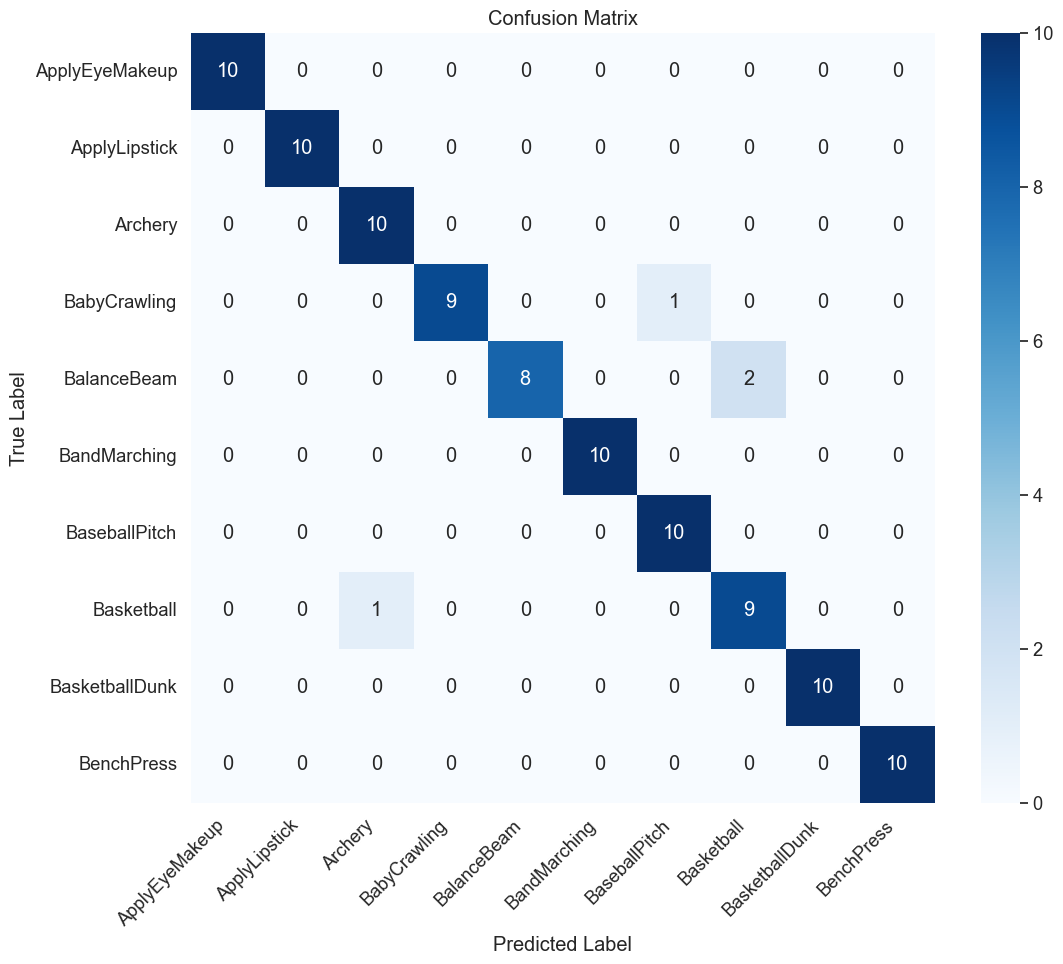

In [62]:
def plot_confusion_matrix_seaborn(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)  # Adjust to fit
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Rotate the tick labels for better alignment
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Show the plot
    plt.show()
    
# Use the class names extracted from the FrameGenerator or dataset preparation step
class_names = fg.class_names  # Assuming class_names are stored in this attribute

# Assuming conf_matrix is your confusion matrix and class_names is the list of class names
plot_confusion_matrix_seaborn(conf_matrix, class_names)


Previously used plots (code) for analysing performance. Now superseeded by Bayesien optimisation so that we can transfer what we have learned here about learning rates on the subset and apply to new codebase for the full dataset. The following is used on the full dataset codebase.

``` # Assuming 'history' is the output from the model.fit() method
history_dict = history.history

# Extract the loss and accuracy for training and validation sets
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plot the loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
```` 

In [63]:
# From this image most predictions are correct, indicated by the high counts along the diagaonal.